In [22]:
import numpy as np
import pandas as pd
import os
import sys
import json
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pathlib import Path


repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root))

from my_utils.utils import load_probe_data

In [3]:
def compute_ece_soft(probs, labels, n_bins=10):
    """
    ECE for probabilistic (soft) labels in [0,1].
    probs: predicted probabilities in [0,1], shape [N]
    labels: target probabilities in [0,1], shape [N]
    """
    probs = np.asarray(probs).reshape(-1)
    labels = np.asarray(labels).reshape(-1)

    if probs.shape[0] != labels.shape[0]:
        raise ValueError(f"Shape mismatch: probs {probs.shape}, labels {labels.shape}")
    if np.any(probs < 0) or np.any(probs > 1):
        raise ValueError("probs must be in [0,1]. Apply sigmoid if you have logits.")
    if np.any(labels < 0) or np.any(labels > 1):
        raise ValueError("labels must be in [0,1] for soft-label ECE.")

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        left, right = bin_edges[i], bin_edges[i + 1]
        # include 1.0 in last bin
        if i == n_bins - 1:
            mask = (probs >= left) & (probs <= right)
        else:
            mask = (probs >= left) & (probs < right)

        if np.any(mask):
            avg_conf = probs[mask].mean()
            avg_true = labels[mask].mean()   # mean target probability
            bin_frac = mask.mean()
            ece += np.abs(avg_conf - avg_true) * bin_frac

    return float(ece)


def reliability_diagram_soft(probs, labels, n_bins=10, title="Reliability diagram (soft labels)", show_hist=True):
    """
    Reliability diagram for soft labels:
      x = mean predicted probability per bin
      y = mean target probability per bin
    """
    probs = np.asarray(probs).reshape(-1)
    labels = np.asarray(labels).reshape(-1)

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    mean_pred = np.full(n_bins, np.nan)
    mean_true = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)

    for i in range(n_bins):
        left, right = bin_edges[i], bin_edges[i + 1]
        if i == n_bins - 1:
            mask = (probs >= left) & (probs <= right)
        else:
            mask = (probs >= left) & (probs < right)

        counts[i] = int(mask.sum())
        if counts[i] > 0:
            mean_pred[i] = probs[mask].mean()
            mean_true[i] = labels[mask].mean()

    if show_hist:
        fig, (ax, axh) = plt.subplots(
            2, 1, figsize=(6, 8), gridspec_kw={"height_ratios": [3, 1]}, sharex=True
        )
    else:
        fig, ax = plt.subplots(figsize=(6, 6))
        axh = None

    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    valid = ~np.isnan(mean_true)
    ax.plot(mean_pred[valid], mean_true[valid], marker="o")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Mean target probability")
    ax.set_title(title)

    if axh is not None:
        axh.bar(centers, counts, width=(bin_edges[1] - bin_edges[0]) * 0.9)
        axh.set_ylabel("Count")
        axh.set_xlabel("Predicted probability bin")

    plt.tight_layout()
    return fig

In [7]:
def sigmoid_np(x):
    x = np.asarray(x)
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid(x): return 1/(1+np.exp(-x))


def sr_to_counts(sr, n_trials=50):
    sr = np.asarray(sr).reshape(-1)
    k = np.rint(sr * n_trials).astype(int)
    k = np.clip(k, 0, n_trials)
    n = np.full_like(k, n_trials, dtype=int)
    return k, n

def fit_platt_binomial(
    logits_cal,
    sr50_cal,
    n_trials=50,
    max_iter=300,
    device="cpu",
):
    """
    Fit Platt scaling parameters (a, b) for:
        p = sigmoid(a * logit + b)
    minimizing binomial NLL using SR@50 -> (k successes out of n trials).
    """
    k_np, n_np = sr_to_counts(sr50_cal, n_trials=n_trials)

    z = torch.as_tensor(np.asarray(logits_cal).reshape(-1), dtype=torch.float32, device=device)
    k = torch.as_tensor(k_np, dtype=torch.float32, device=device)
    n = torch.as_tensor(n_np, dtype=torch.float32, device=device)

    # Initialize: a=1, b=0 (identity-ish)
    a = torch.tensor(1.0, dtype=torch.float32, device=device, requires_grad=True)
    b = torch.tensor(0.0, dtype=torch.float32, device=device, requires_grad=True)

    opt = torch.optim.LBFGS([a, b], lr=0.5, max_iter=max_iter, line_search_fn="strong_wolfe")

    def closure():
        opt.zero_grad()
        s = a * z + b
        # Binomial NLL per example: -[k*logsigmoid(s) + (n-k)*logsigmoid(-s)]
        loss = -(k * F.logsigmoid(s) + (n - k) * F.logsigmoid(-s)).mean()
        loss.backward()
        return loss

    opt.step(closure)

    a_hat = float(a.detach().cpu().item())
    b_hat = float(b.detach().cpu().item())
    return a_hat, b_hat

def apply_platt(logits, a, b):
    logits = np.asarray(logits)
    return sigmoid_np(a * logits + b)

In [20]:
MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B-Instruct"
MODEL_ALIAS = "-".join(MODEL_NAME.split("/"))
K=50
TEMPERATURE=0.6

data = load_probe_data(MODEL_NAME=MODEL_NAME, PROBING_DATASET="MATH", K=K, TEMPERATURE=TEMPERATURE)

In [11]:
print(f"Benchmark score: {data["avg_benchmark_score"]}")
print(f"Probe test performance: {data["test_score"]}")

Benchmark score: 0.724508000317961
Probe test performance: 0.7093885926828293


Num bins: 10
Platt params: {'a': 7.335192680358887, 'b': -3.8320374488830566}
ECE before: 0.16280858612787225
Test ECE after Platt scaling: 0.0774


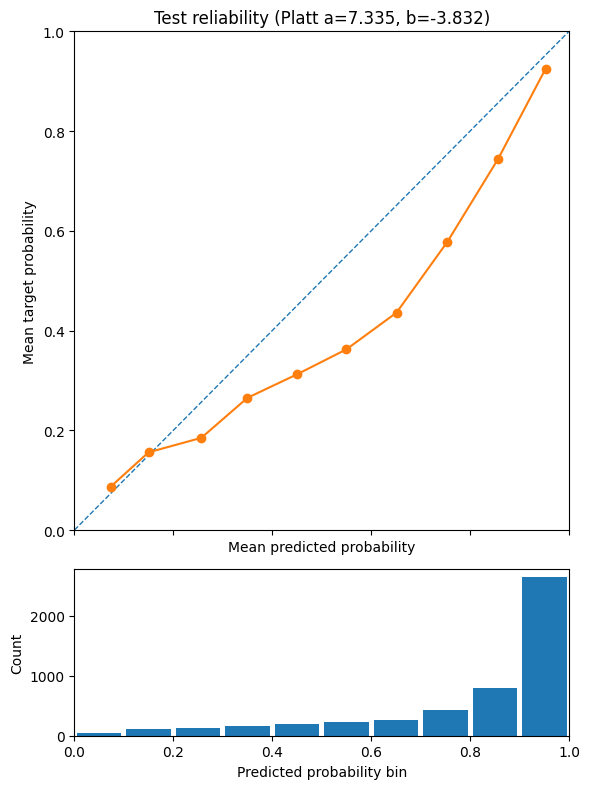

In [13]:
# -------- Usage (calibrate on train-split, evaluate on test) --------
logits_train = np.asarray(data["train_predictions"])
sr50_train   = np.asarray(data["train_actual"])

logits_test  = np.asarray(data["test_predictions"])
sr50_test    = np.asarray(data["test_actual"])

# Option A (recommended): hold out calibration subset from TRAIN
rng = np.random.default_rng(42)
idx = np.arange(len(logits_train))
rng.shuffle(idx)
cal_frac = 0.2
n_cal = int(round(cal_frac * len(idx)))
cal_idx = idx[:n_cal]

logits_cal = logits_train[cal_idx]
sr50_cal   = sr50_train[cal_idx]

n_bins=10
print(f"Num bins: {n_bins}" )

a, b = fit_platt_binomial(logits_cal, sr50_cal, n_trials=50, device="cpu")
print("Platt params:", {"a": a, "b": b})

# Calibrated test probabilities
probs_test_platt = apply_platt(logits_test, a, b)

ece_before = compute_ece_soft(sigmoid(logits_test), sr50_test, n_bins=n_bins)
print("ECE before:", ece_before)

# Example: compute soft-label ECE with your function
ece_after = compute_ece_soft(probs_test_platt, sr50_test, n_bins=n_bins)
print(f"Test ECE after Platt scaling: {ece_after:.4f}")

_ = reliability_diagram_soft(probs_test_platt, sr50_test, n_bins=n_bins,
                             title=f"Test reliability (Platt a={a:.3f}, b={b:.3f})",
                             show_hist=True)
plt.show()

In [ ]:
calibrated_probe = {
    "best_layer": data["best_layer"],
    "best_position": data["best_position"],
    "platt_a": a,
    "platt_b": b,
    "K": K,
}

In [17]:
def add_calibrated_probe(
    MODEL_NAME: str,
    PROBING_DATASET: str,
    K: int,
    TEMPERATURE: float,
    platt_a: float,
    platt_b: float,
) -> dict:
    """
    Load best_probe_predictions.json, attach a `calibrated_probe` field, and save.

    calibrated_probe = {
        "best_layer": <from existing probe_data>,
        "best_position": <from existing probe_data>,
        "platt_a": platt_a,
        "platt_b": platt_b,
        "K": K,
    }
    """
    MODEL_ALIAS = "-".join(MODEL_NAME.split("/"))
    GEN_STR = f"maxlen_3000_k_{K}_temp_{TEMPERATURE}"
    probe_path = Path(f"../probe_results/DATA/SR_DATA/{PROBING_DATASET}/{MODEL_ALIAS}_{GEN_STR}/best_probe_predictions.json")

    # 1) Load existing probe data
    with probe_path.open("r") as f:
        data = json.load(f)

    # 2) Build calibrated probe block
    calibrated_probe = {
        "best_layer": data["best_layer"],
        "best_position": data["best_position"],
        "platt_a": float(platt_a),
        "platt_b": float(platt_b),
        "K": int(K),
    }

    # 3) Attach to dict
    data["calibrated_probe"] = calibrated_probe

    # 4) Save back to disk
    with probe_path.open("w") as f:
        json.dump(data, f, indent=2)

    return data


In [18]:
updated = add_calibrated_probe(
    MODEL_NAME=MODEL_NAME,
    PROBING_DATASET="MATH",
    K=K,
    TEMPERATURE=TEMPERATURE,
    platt_a=a,
    platt_b=b
)

In [19]:
print(updated["calibrated_probe"])


{'best_layer': 18, 'best_position': -1, 'platt_a': 7.335192680358887, 'platt_b': -3.8320374488830566, 'K': 50}


In [30]:
MODEL_NAME

'Qwen/Qwen2.5-Math-1.5B-Instruct'

In [40]:
DATASETS = ["opencompass/AIME2025","gneubig/aime-1983-2024", "DigitalLearningGmbH/MATH-lighteval", "openai/gsm8k"]

for DATASET_NAME in DATASETS:
    DATASET_NAME = "_".join(DATASET_NAME.split("/"))
    print(f"====================================\n📜 LOADING {DATASET_NAME} 📜\n====================================")
    PROBE_PREDICTIONS_PATH = f"../probe_results/DATA/Lablled_SR/MATH_probe/{DATASET_NAME}/{MODEL_ALIAS}_maxlen_3000_k_{K}_temp_{TEMPERATURE}/scored.parquet"

    labelled_df = pd.read_parquet(PROBE_PREDICTIONS_PATH)

    print("📊 Raw score: \n")
    print(labelled_df["score_raw"].describe())
    print("**************** \n")

    print("📊 Sigmoid score: \n")
    print(labelled_df["score"].describe())
    print("**************** \n")

    print("📊 Calibrated Raw score: \n")
    labelled_df["calibrated_raw_score"] = (labelled_df["score_raw"] * a) + b
    print(labelled_df["calibrated_raw_score"].describe())
    print("**************** \n")

    print("📊 Calibrated Sigmoid score: \n")
    labelled_df["calibrated_score"] = sigmoid(labelled_df["calibrated_raw_score"])
    print(labelled_df["calibrated_score"].describe())
    print("**************** \n")
    print("======================================\n")

    labelled_df.to_parquet(PROBE_PREDICTIONS_PATH)

📜 LOADING opencompass_AIME2025 📜
📊 Raw score: 

count    15.000000
mean      0.203987
std       0.189476
min      -0.092898
25%       0.067630
50%       0.167437
75%       0.333565
max       0.602231
Name: score_raw, dtype: float64
**************** 

📊 Sigmoid score: 

count    15.000000
mean      0.550345
std       0.046359
min       0.476792
25%       0.516901
50%       0.541762
75%       0.582617
max       0.646167
Name: score, dtype: float64
**************** 

📊 Calibrated Raw score: 

count    15.000000
mean     -2.335751
std       1.389840
min      -4.513465
25%      -3.335958
50%      -2.603852
75%      -1.385275
max       0.585445
Name: calibrated_raw_score, dtype: float64
**************** 

📊 Calibrated Sigmoid score: 

count    15.000000
mean      0.147248
std       0.174954
min       0.010842
25%       0.034360
50%       0.068891
75%       0.201439
max       0.642319
Name: calibrated_score, dtype: float64
**************** 


📜 LOADING gneubig_aime-1983-2024 📜
📊 Raw score: 



In [23]:
labelled_df = pd.read_parquet(PROBE_PREDICTIONS_PATH)

In [24]:
labelled_df["score_raw"].describe()

count    933.000000
mean       0.408026
std        0.207655
min       -0.114141
25%        0.259138
50%        0.393253
75%        0.560032
max        1.060312
Name: score_raw, dtype: float64

In [25]:
labelled_df["score"].describe()

count    933.000000
mean       0.599574
std        0.049323
min        0.471496
25%        0.564425
50%        0.597066
75%        0.636460
max        0.742750
Name: score, dtype: float64